In [1]:
#Import packages

import numpy as np
from numpy.typing import NDArray
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

#Auxiliary functions

def onehot2cat(y:NDArray) -> NDArray:
    '''Convert y in one_hot to categorical'''
    return np.argmax(y, axis=1) 


def loadDataset(fn:str, toCat:bool=False) -> NDArray:
    '''load dataset'''
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        
    X = data['X'] 
    if toCat: y = onehot2cat(data['Y'])
    else:     y = data['Y'] 
    
    return X, y


def saveSKLModel(fn:str, model) -> None:
    '''save SKLearn model as pickle'''
    with open(fn, 'wb') as f:
        pickle.dump(model, f)
        
#load dataset

fnt = 'wtdt-part.pickle'
X, y = loadDataset(fnt, toCat=True)
print(X.shape)
print(y.shape)

(14000, 787)
(14000,)


In [17]:
model = RandomForestClassifier(n_estimators= 278, max_depth= 9, max_features= 'log2', min_samples_split= 6, min_samples_leaf= 1)
model.fit(X,y)
saveSKLModel("T1-randomForest.pickle", model)

In [22]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def objective_function(model, X, y, weight_accuracy=0.7, weight_stability=0.2, weight_class_penalty=0.1, target_class=None):
    """
    Objective function that balances accuracy with feature importance stability and class-specific penalties.
    
    Parameters:
    - model: The classifier model (e.g., RandomForestClassifier).
    - X: The feature matrix.
    - y: The target variable.
    - weight_accuracy: Weight for accuracy in the final combined score.
    - weight_stability: Weight for feature importance stability in the final score.
    - weight_class_penalty: Weight for penalizing the performance on a specific class.
    - target_class: The specific class you want to penalize (if any).
    
    Returns:
    - Combined score based on accuracy, stability, and class penalty.
    """
    accuracies = []
    importances_list = []
    class_performance = []

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    for train_idx, val_idx in skf.split(X, y):
        # Train and validate the model
        model.fit(X[train_idx], y[train_idx])
        accuracy = model.score(X[val_idx], y[val_idx])  # Calculate accuracy on validation set
        accuracies.append(accuracy)
        
        # Store feature importances
        importances_list.append(model.feature_importances_)
        
        # Calculate performance on each class
        if target_class is not None:
            class_accuracy = np.sum(y[val_idx] == target_class) / len(val_idx)  # Accuracy for target class
            class_performance.append(class_accuracy)

    # Calculate mean and variance of feature importances
    importances_array = np.array(importances_list)
    variance_importances = np.var(importances_array, axis=0)
    mean_variance = np.mean(variance_importances)  # Average variance across features

    # Calculate the mean accuracy
    mean_accuracy = np.mean(accuracies)

    # Penalize the performance on the specific class
    if target_class is not None:
        mean_class_accuracy = np.mean(class_performance)
        class_penalty = 1 - mean_class_accuracy  # Penalize lower performance on the specific class
    else:
        class_penalty = 0

    # Normalize metrics to balance their scales
    normalized_accuracy = mean_accuracy  # Accuracy is already on a normalized scale (0 to 1)
    normalized_stability = 1 / (1 + mean_variance)  # Lower variance means better stability

    # Combined score
    combined_score = (weight_accuracy * normalized_accuracy) + (weight_stability * normalized_stability) - (weight_class_penalty * class_penalty)

    # Print evaluation metrics for debugging
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Mean Feature Importance Variance: {mean_variance:.4f}")
    print(f"Normalized Stability: {normalized_stability:.4f}")
    print(f"Class Performance (for target class): {np.mean(class_performance) if target_class else 'N/A'}")
    print(f"Class Penalty: {class_penalty:.4f}")
    print(f"Combined Score: {combined_score:.4f}")

    return combined_score

# Example of using the function
target_class = 3  # If you know which class is problematic
combined_score = objective_function(model, X, y, weight_accuracy=0.7, weight_stability=0.2, weight_class_penalty=0.1, target_class=target_class)



print(objective_function(model, X, y))

Mean Accuracy: 0.9996
Mean Feature Importance Variance: 0.0000
Normalized Stability: 1.0000
Feature Importance Balance (Entropy): 6.0871
Combined Score: 0.8280
0.827962947166482


In [13]:
model.fit(X,y)
saveSKLModel("T1-randomForest.pickle", model)

In [4]:
#Import packages

import numpy as np
from numpy.typing import NDArray
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
#Auxiliary functions

def onehot2cat(y:NDArray) -> NDArray:
    '''Convert y in one_hot to categorical'''
    return np.argmax(y, axis=1) 


def loadDataset(fn:str, toCat:bool=False) -> NDArray:
    '''load dataset'''
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        
    X = data['X'] 
    if toCat: y = onehot2cat(data['Y'])
    else:     y = data['Y'] 
    
    return X, y


def saveSKLModel(fn:str, model) -> None:
    '''save SKLearn model as pickle'''
    with open(fn, 'wb') as f:
        pickle.dump(model, f)

#load dataset

fnt = 'wtdt-part.pickle'
X, y = loadDataset(fnt, toCat=True)
print(X.shape)

# Split the dataset into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, shuffle=False)
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)

print("Training Set Shape:", X_train.shape, y_train.shape)
print("Validation Set Shape:", X_val.shape, y_val.shape)
print("Test Set Shape (Unshuffled):", X_test.shape, y_test.shape)


# Train the Random Forest model on the training set
model = RandomForestClassifier()
model.fit(X_train_shuffled, y_train_shuffled)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# After validation, you can test the model on the test set (optional)
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Save the trained model
saveSKLModel("T1-randomForest.pickle", model)


(14000, 787)
Training Set Shape: (10080, 787) (10080,)
Validation Set Shape: (1120, 787) (1120,)
Test Set Shape (Unshuffled): (2800, 787) (2800,)
Validation Accuracy: 0.26160714285714287
Test Accuracy: 0.05821428571428571


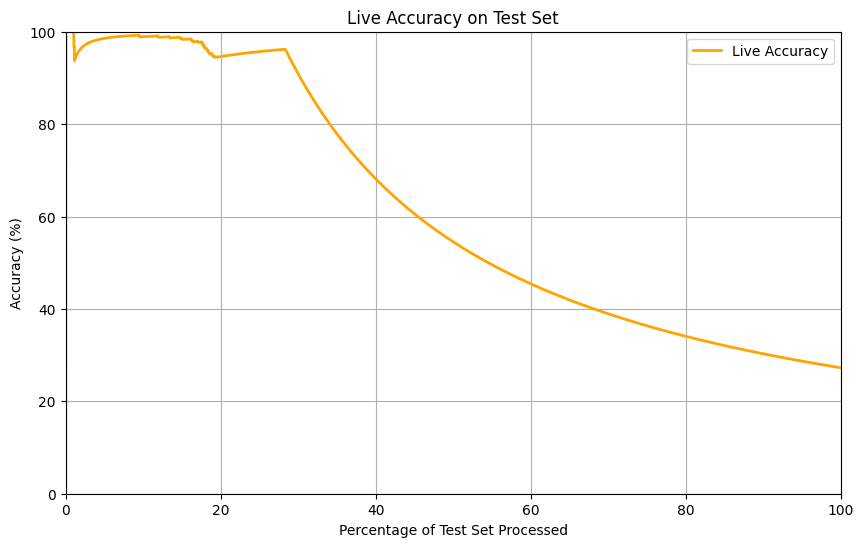

In [27]:
# Initialize variables for live accuracy calculation
cumulative_correct = 0  # Counter for correct predictions
live_accuracies = [0]  # Start explicitly at 0% accuracy
total_test_samples = len(y_test_windows)

# Iterate through test samples and calculate live accuracy
for i, (true_label, pred_label) in enumerate(zip(y_test_windows, y_test_pred), 1):
    if true_label == pred_label:
        cumulative_correct += 1
    live_accuracy = cumulative_correct / i  # Accuracy up to current sample
    live_accuracies.append(live_accuracy)

# Convert live accuracies to percentage
live_accuracies = [accuracy * 100 for accuracy in live_accuracies]

# X-axis: Percentage of test set processed
percentages = np.linspace(0, 100, total_test_samples + 1)  # Include starting point for 0%

# Plot the live accuracy graph
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(percentages, live_accuracies, label="Live Accuracy", color='orange', linewidth=2)
plt.title("Live Accuracy on Test Set")
plt.xlabel("Percentage of Test Set Processed")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)  # Accuracy percentage range
plt.xlim(0, 100)  # Full dataset processing range
plt.legend()
plt.grid(True)
plt.show()


Dataset Shape: (14000, 787)
Training Set Shape: (9800, 787) (9800,)
Validation Set Shape: (2800, 787) (2800,)
Test Set Shape (Unshuffled): (1400, 787) (1400,)
Training Distribution: Counter({np.int64(0): 2000, np.int64(1): 2000, np.int64(2): 2000, np.int64(3): 2000, np.int64(4): 1800})
Validation Distribution: Counter({np.int64(5): 2000, np.int64(6): 600, np.int64(4): 200})
Test Distribution: Counter({np.int64(6): 1400})
Sliding Window Shapes:
Training: (4896, 7870) (4896,)
Validation: (1396, 7870) (1396,)
Test: (1391, 7870) (1391,)
Validation Accuracy: 0.06876790830945559
Test Accuracy: 0.0


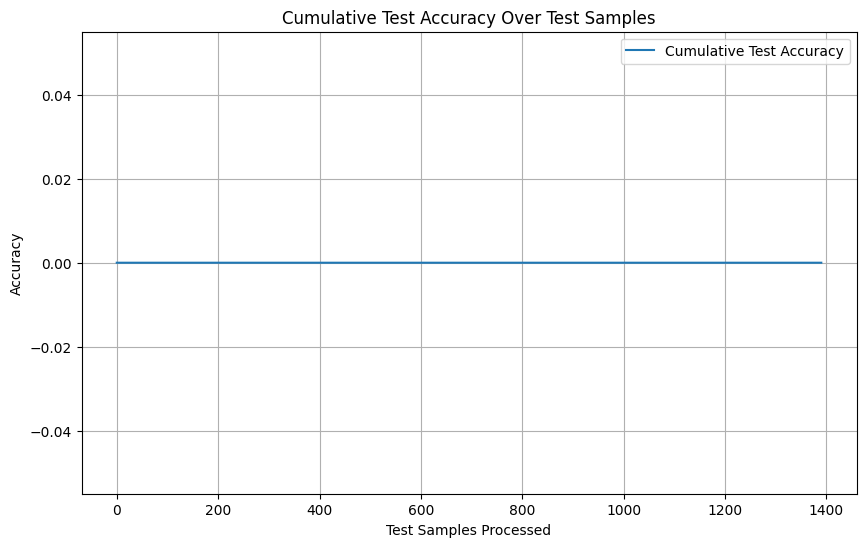